In [ ]:
#@title file uploader from drive
!pip install -U -q PyDrive


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')


import io
from googleapiclient.http import MediaIoBaseDownload

for file_id in file_list: 
  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    _, done = downloader.next_chunk()

  fileId = drive.CreateFile({'id': file_id }) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
  print(fileId['title'])  
  fileId.GetContentFile(fileId['title'])  # Save Drive file as a local file

#!unzip {fileId['title']}


us_all_train_test.zip
spec_all_train_test.zip
all_models.zip


In [ ]:
!unzip /content/all_models.zip -d /content/all_models
!unzip /content/spec_all_train_test.zip -d /content/spec_all_train_test
!unzip /content/us_all_train_test.zip -d /content/us_all_train_test

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.preprocessing.image import DirectoryIterator,DataFrameIterator
import numpy as np



path_us_train = "/content/us_all_train_test/train"
path_us_test = "/content/us_all_train_test/test"


h = 96
w = 96
# timesteps = 3

################ US images ##############

datagen = ImageDataGenerator(
#     rotation_range=2,
# width_shift_range=2.0,
# height_shift_range=2.0,
# brightness_range=(10,5),
# shear_range=5.0,
# zoom_range=5.0,
# channel_shift_range=5.0  
)

train_generator_us = datagen.flow_from_directory(path_us_train,class_mode='categorical', color_mode ='grayscale', shuffle = False, target_size =(h,w),subset='training')

datagen_test = ImageDataGenerator(
#     rotation_range=2,
# width_shift_range=2.0,
# height_shift_range=2.0,
# brightness_range=(10,5),
# shear_range=5.0,
# zoom_range=5.0,
# channel_shift_range=5.0  
)

test_generator_us = datagen_test.flow_from_directory(path_us_test,class_mode='categorical',color_mode ='grayscale',shuffle = False,  target_size =(h,w),subset='training')

################ Spectrogram images ##############


spec_datagen = ImageDataGenerator()

h = 96
w = 96

path_spec_train = "/content/spec_all_train_test/train"
path_spec_test = "/content/spec_all_train_test/test"



train_generator_spec = spec_datagen.flow_from_directory(path_spec_train,class_mode='binary', color_mode ='rgb', shuffle = False, target_size =(h,w),subset='training')

spec_datagen_test = ImageDataGenerator()

test_generator_spec = spec_datagen_test.flow_from_directory(path_spec_test,class_mode='binary',color_mode ='rgb',shuffle = False,  target_size =(h,w),subset='training')


                                        
# # ,rotation_range=2,
# # width_shift_range=2.0,
# # height_shift_range=2.0,
# # brightness_range=(10,5),
# # shear_range=5.0,
# # ,zoom_range=5.0
# # channel_shift_range=5.0  




Found 8787 images belonging to 6 classes.
Found 4395 images belonging to 6 classes.
Found 2929 images belonging to 6 classes.
Found 1465 images belonging to 6 classes.


In [ ]:
def load_data_from_generators_only_for_baseline(generator,timestep,color_mode ='grayscale',target_size =(96,96)):

    data_frames = []

    dat_labels = [];

    for i in range(1,len(generator.filepaths),timestep):

        time_dist_data = []

        time_dist_data.append(img_to_array(load_img(generator.filepaths[i],color_mode=color_mode,target_size=target_size)))

        dat_labels.append(generator.labels[i])

        data_frames.append(time_dist_data)

    return np.array(data_frames),np.array(dat_labels)


# this is for baseline CNN model

train_us_data_baseline,train_labels_us_baseline = load_data_from_generators_only_for_baseline(train_generator_us,timestep=3)

test_us_data_baseline,test_labels_us_baseline = load_data_from_generators_only_for_baseline(test_generator_us,timestep=3)

train_labels_us_baseline = tf.keras.utils.to_categorical(train_labels_us_baseline)
test_labels_us_baseline  =tf.keras.utils.to_categorical(test_labels_us_baseline)

train_us_data_baseline = train_us_data_baseline.reshape(2929, 96, 96, 1)
test_us_data_baseline = test_us_data_baseline.reshape(1465, 96, 96, 1)

print(train_us_data_baseline.shape)
print(test_us_data_baseline.shape)

(2929, 96, 96, 1)
(1465, 96, 96, 1)


In [ ]:
def load_data_from_generators(generator,timestep,color_mode ='grayscale',target_size =(96,96)):

    data_frames = []

    dat_labels = [];

    for i in range(0,len(generator.filepaths),timestep):

        time_dist_data = []

        for k in range(timestep):

            time_dist_data.append(img_to_array(load_img(generator.filepaths[i+k],color_mode=color_mode,target_size=target_size)))

        dat_labels.append(generator.labels[i])

        data_frames.append(time_dist_data)

    return np.array(data_frames),np.array(dat_labels)

train_us_data,train_labels_us = load_data_from_generators(train_generator_us,timestep=3)

test_us_data,test_labels_us = load_data_from_generators(test_generator_us,timestep=3)

train_spec_data,train_labels_spec = load_data_from_generators(train_generator_spec,timestep=1,color_mode='rgb')

test_spec_data,test_labels_spec = load_data_from_generators(test_generator_spec,timestep=1,color_mode='rgb')

print(train_us_data.shape)
print(test_us_data.shape)

train_spec_data = np.squeeze(train_spec_data)

print(train_spec_data.shape)

test_spec_data = np.squeeze(test_spec_data)

print(test_spec_data.shape)

train_labels_us = tf.keras.utils.to_categorical(train_labels_us)

test_labels_us  =tf.keras.utils.to_categorical(test_labels_us)

print(train_labels_us.shape)
print(test_labels_us.shape)


(2929, 3, 96, 96, 1)
(1465, 3, 96, 96, 1)
(2929, 96, 96, 3)
(1465, 96, 96, 3)
(2929, 6)
(1465, 6)


In [ ]:
# only baseline

from keras.applications.resnet import ResNet50
# load model
model_resnet = ResNet50(input_shape=(96, 96, 1),weights=None,include_top=False)

for layers in model_resnet.layers:
            layers.trainable=True
last_output = model_resnet.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(nbout, activation = 'softmax')(vgg_x)
model_baseline = Model(model_resnet.input, vgg_x)
# model_baseline.summary()


In [ ]:
opt = SGD(lr=0.001)
model_baseline.compile(loss = "categorical_crossentropy", optimizer =opt,metrics=['accuracy'])
model_baseline.fit(train_us_data_baseline,train_labels_us_baseline, shuffle=True,batch_size=10,validation_data=(test_us_data_baseline,test_labels_us_baseline),epochs =10)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
293/293 [==============================] - 45s 138ms/step - loss: 1.7160 - accuracy: 0.3168 - val_loss: 1.7600 - val_accuracy: 0.1918
Epoch 2/10
293/293 [==============================] - 38s 130ms/step - loss: 0.8841 - accuracy: 0.6272 - val_loss: 0.8781 - val_accuracy: 0.6642
Epoch 3/10
293/293 [==============================] - 38s 130ms/step - loss: 0.5515 - accuracy: 0.7774 - val_loss: 1.8919 - val_accuracy: 0.4089
Epoch 4/10
293/293 [==============================] - 38s 130ms/step - loss: 0.4454 - accuracy: 0.8173 - val_loss: 0.8661 - val_accuracy: 0.7338
Epoch 5/10
293/293 [==============================] - 38s 130ms/step - loss: 0.3682 - accuracy: 0.8600 - val_loss: 0.7606 - val_accuracy: 0.7270
Epoch 6/10
293/293 [==============================] - 38s 131ms/step - loss: 0.3166 - accuracy: 0.8856 - val_loss: 0.7946 - val_accuracy: 0.7563
Epoch 7/10
293/293 [==============================] - 39s 133ms/step - loss: 0.2542 - accuracy: 0.9088 - val_loss: 0.9857 - val_ac

In [ ]:
model_baseline.fit(train_us_data_baseline,train_labels_us_baseline, shuffle=True,batch_size=10,validation_data=(test_us_data_baseline,test_labels_us_baseline),epochs =10)


Epoch 1/10
293/293 [==============================] - 38s 131ms/step - loss: 0.0782 - accuracy: 0.9744 - val_loss: 1.4246 - val_accuracy: 0.6874
Epoch 2/10
293/293 [==============================] - 39s 132ms/step - loss: 0.0338 - accuracy: 0.9901 - val_loss: 1.6821 - val_accuracy: 0.7003
Epoch 3/10
293/293 [==============================] - 39s 132ms/step - loss: 0.0169 - accuracy: 0.9962 - val_loss: 1.6568 - val_accuracy: 0.6860
Epoch 4/10
293/293 [==============================] - 38s 130ms/step - loss: 0.0049 - accuracy: 0.9997 - val_loss: 1.5426 - val_accuracy: 0.6997
Epoch 5/10
293/293 [==============================] - 39s 132ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.8170 - val_accuracy: 0.7031
Epoch 6/10
293/293 [==============================] - 38s 130ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.8922 - val_accuracy: 0.6969
Epoch 7/10
293/293 [==============================] - 38s 130ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 1.8236 - val_ac

In [ ]:
# only us

nbout = 6

model_f = action_model((tstep,h,w,channel), nbout)

model_f.add(Dense(nbout, activation='softmax'))


opt = SGD(lr=0.001)
model_f.compile(loss = "categorical_crossentropy", optimizer =opt,metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# only spec

nbout = 6
tstep = 1
channel = 3

train_spec_data_reshape  = train_spec_data.reshape( train_spec_data.shape[0], 1, train_spec_data.shape[1],train_spec_data.shape[2], train_spec_data.shape[3] )
test_spec_data_reshape  = test_spec_data.reshape( test_spec_data.shape[0], 1, test_spec_data.shape[1],test_spec_data.shape[2], test_spec_data.shape[3] )

# train_spec_data_reshape.shape
model_s = action_model((tstep,h,w,channel), nbout)

model_s.add(Dense(nbout, activation='softmax'))


opt = SGD(lr=0.001)
model_s.compile(loss = "categorical_crossentropy", optimizer =opt,metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model_s.fit(train_spec_data_reshape,train_labels_us, shuffle=True,batch_size=10,validation_data=(test_spec_data_reshape,test_labels_us),epochs =20)


Epoch 1/20
293/293 [==============================] - 42s 131ms/step - loss: 1.7622 - accuracy: 0.2035 - val_loss: 1.7324 - val_accuracy: 0.2225
Epoch 2/20
293/293 [==============================] - 37s 126ms/step - loss: 1.6714 - accuracy: 0.4223 - val_loss: 1.6098 - val_accuracy: 0.5447
Epoch 3/20
293/293 [==============================] - 37s 126ms/step - loss: 1.6131 - accuracy: 0.4985 - val_loss: 1.5702 - val_accuracy: 0.5850
Epoch 4/20
293/293 [==============================] - 37s 126ms/step - loss: 1.5474 - accuracy: 0.5275 - val_loss: 1.4925 - val_accuracy: 0.5898
Epoch 5/20
293/293 [==============================] - 37s 127ms/step - loss: 1.4692 - accuracy: 0.5579 - val_loss: 1.4489 - val_accuracy: 0.5795
Epoch 6/20
293/293 [==============================] - 37s 126ms/step - loss: 1.3904 - accuracy: 0.5719 - val_loss: 1.3426 - val_accuracy: 0.6082
Epoch 7/20
293/293 [==============================] - 37s 126ms/step - loss: 1.3097 - accuracy: 0.5889 - val_loss: 1.2145 - val_ac

In [ ]:
# us and spectrogram

model_f = action_model((tstep,h,w,channel), nbout)

model_conv = conv2DNet((h,w,3))

# model_conv.add(Dense(nbout, activation='sigmoid'))

merged_model = Concatenate()([model_f.output, model_conv.output])

# output_layer_2 = Dense(128, activation='sigmoid')(merged_model)

# output_layer_1 = Dense(64, activation='sigmoid')(output_layer_2)

output_layer = Dense(nbout, activation='softmax')(merged_model)

model_t3 = Model(inputs =[model_f.input,model_conv.input],outputs = [output_layer])

opt = SGD(lr=0.001)
model_t3.compile(loss = "categorical_crossentropy", optimizer =opt,metrics=['accuracy'])
# merged_model.compile(loss = "binary_crossentropy", optimizer =opt,metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model_t3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_18_input (InputLayer)    [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 96, 96, 128)  18944       conv2d_18_input[0][0]            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 96, 96, 128)  147584      conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 96, 96, 64)   73792       conv2d_19[0][0]                  
______________________________________________________________________________________________

In [ ]:
# for us and spectrogram
model_t3.fit([train_us_data,train_spec_data],train_labels_us,validation_data =([test_us_data,test_spec_data],test_labels_us), shuffle=True,batch_size=10, epochs =20)

Epoch 1/20
293/293 [==============================] - 109s 373ms/step - loss: 1.2644 - accuracy: 0.4944 - val_loss: 1.0206 - val_accuracy: 0.5952
Epoch 2/20
293/293 [==============================] - 106s 361ms/step - loss: 1.0939 - accuracy: 0.5616 - val_loss: 0.9359 - val_accuracy: 0.6177
Epoch 3/20
293/293 [==============================] - 106s 361ms/step - loss: 0.9412 - accuracy: 0.6501 - val_loss: 0.7792 - val_accuracy: 0.7399
Epoch 4/20
293/293 [==============================] - 106s 362ms/step - loss: 0.7757 - accuracy: 0.7450 - val_loss: 0.6568 - val_accuracy: 0.8137
Epoch 5/20
293/293 [==============================] - 106s 362ms/step - loss: 0.6157 - accuracy: 0.8016 - val_loss: 0.6130 - val_accuracy: 0.8027
Epoch 6/20
293/293 [==============================] - 106s 362ms/step - loss: 0.5564 - accuracy: 0.8173 - val_loss: 0.6262 - val_accuracy: 0.7611
Epoch 7/20
293/293 [==============================] - 106s 362ms/step - loss: 0.5160 - accuracy: 0.8266 - val_loss: 0.4442 -

In [ ]:
# model_t3.fit([train_us_data,train_spec_data],train_labels_us,validation_data =([test_us_data,test_spec_data],test_labels_us), shuffle=True,batch_size =4,epochs =20)

# for us and spectrogram
# model_t3.fit([train_us_data,train_spec_data],train_labels_us, shuffle=True,batch_size=10, epochs =10)

# for us
model_f.fit(train_us_data,train_labels_us, shuffle=True,batch_size=10,validation_data=(test_us_data,test_labels_us),epochs =20)



Epoch 1/20
293/293 [==============================] - 86s 281ms/step - loss: 1.7768 - accuracy: 0.2144 - val_loss: 1.5998 - val_accuracy: 0.3304
Epoch 2/20
293/293 [==============================] - 81s 276ms/step - loss: 1.6213 - accuracy: 0.4326 - val_loss: 1.3781 - val_accuracy: 0.4765
Epoch 3/20
293/293 [==============================] - 83s 282ms/step - loss: 1.2989 - accuracy: 0.5746 - val_loss: 1.2800 - val_accuracy: 0.5147
Epoch 4/20
293/293 [==============================] - 81s 276ms/step - loss: 1.0068 - accuracy: 0.7002 - val_loss: 1.4815 - val_accuracy: 0.4669
Epoch 5/20
293/293 [==============================] - 81s 276ms/step - loss: 0.7530 - accuracy: 0.7897 - val_loss: 0.9365 - val_accuracy: 0.6567
Epoch 6/20
293/293 [==============================] - 81s 275ms/step - loss: 0.6535 - accuracy: 0.8266 - val_loss: 1.5072 - val_accuracy: 0.4157
Epoch 7/20
293/293 [==============================] - 81s 275ms/step - loss: 0.6980 - accuracy: 0.8047 - val_loss: 1.2146 - val_ac

In [ ]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
from keras.models import Sequential
# from keras.applications.resnet50 import ResNet50

from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Dense,Flatten,TimeDistributed, Conv3D,MaxPooling3D, Concatenate
from keras.models import Sequential,Model
from tensorflow.keras.optimizers import SGD, Adam

from keras.regularizers import l2
from keras.callbacks import  History
# from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv1D,BatchNormalization,MaxPool1D,Dense,Flatten,TimeDistributed
from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import LSTM,Bidirectional
from keras.models import Sequential
from keras.layers import Conv1D,BatchNormalization,MaxPool1D,Dense,Flatten,TimeDistributed
# from keras.applications.resnet50 import ResNet50


channel = 1
tstep = 3
nbout = 6


from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(h, w, channel)):
    momentum = .9
    model = Sequential()

    model.add(Conv2D(128, (7,7), input_shape=shape, padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(BatchNormalization(momentum=momentum))

    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(BatchNormalization(momentum=momentum))

        
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(BatchNormalization(momentum=momentum))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(BatchNormalization(momentum=momentum))


    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(BatchNormalization(momentum=momentum))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(BatchNormalization(momentum=momentum))
    

    # flatten...
    model.add(GlobalMaxPool2D())
    return model


from keras.layers import TimeDistributed, GRU, Dense, Dropout
def action_model(shape=(tstep, h, w, channel), nbout=2):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = Sequential()

    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))


    model.add(Bidirectional(LSTM(20, activation='relu')))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    # model.add(Dense(nbout, activation='sigmoid'))
    return model

    
def conv2DNet(shape=(h, w, channel)):
    momentum = .9
    model = Sequential()

    model.add(Conv2D(128, (7,7), input_shape=shape, padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(BatchNormalization(momentum=momentum))

    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(BatchNormalization(momentum=momentum))


    # flatten...
    model.add(GlobalMaxPool2D())
    return model



In [ ]:

from keras.models import model_from_json
# serialize model to JSON
model_json = model_baseline.to_json()
with open("model_base_fair_all_phonemes.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_baseline.save_weights("model_base_fair_all_phonemes.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model_base_fair_all_phonemes.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_base_fair_all_phonemes.h5")
print("Loaded model from disk")
 
##### evaluate loaded model on test data

# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))



/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk
Loaded model from disk


In [ ]:
# fair baseline

print("Evaluate on test data")
results = model_baseline.evaluate(test_us_data_baseline,test_labels_us_baseline, batch_size=10)
print("test loss, test acc:", results)

# # Generate predictions (probabilities -- the output of the last layer)
# # on new data using `predict`
# print("Generate predictions for 3 samples")
# predictions = model.predict(x_test[:3])
# print("predictions shape:", predictions.shape)

Evaluate on test data
147/147 [==============================] - 5s 36ms/step - loss: 1.9571 - accuracy: 0.6976
test loss, test acc: [1.9571088552474976, 0.6976109147071838]


In [ ]:
print("Evaluate on test data")
results = model_s.evaluate(test_spec_data_reshape,test_labels_us, batch_size=10)
print("test loss, test acc:", results)

# # Generate predictions (probabilities -- the output of the last layer)
# # on new data using `predict`
# print("Generate predictions for 3 samples")
# predictions = model.predict(x_test[:3])
# print("predictions shape:", predictions.shape)

Evaluate on test data
147/147 [==============================] - 4s 30ms/step - loss: 0.8239 - accuracy: 0.6662
test loss, test acc: [0.8239193558692932, 0.6662116050720215]


In [ ]:
print("Evaluate on test data")
results = model_t3.evaluate([test_us_data,test_spec_data],test_labels_us, batch_size=10)
print("test loss, test acc:", results)

# # Generate predictions (probabilities -- the output of the last layer)
# # on new data using `predict`
# print("Generate predictions for 3 samples")
# predictions = model.predict(x_test[:3])
# print("predictions shape:", predictions.shape)

Evaluate on test data
147/147 [==============================] - 13s 85ms/step - loss: 0.3402 - accuracy: 0.8840
test loss, test acc: [0.3401951491832733, 0.8839590549468994]


In [ ]:
# only us data 
print("Evaluate on test data")
results = model_f.evaluate(test_us_data,test_labels_us, batch_size=10)
print("test loss, test acc:", results)

# # Generate predictions (probabilities -- the output of the last layer)
# # on new data using `predict`
# print("Generate predictions for 3 samples")
# predictions = model.predict(x_test[:3])
# print("predictions shape:", predictions.shape)

Evaluate on test data
147/147 [==============================] - 9s 61ms/step - loss: 0.9523 - accuracy: 0.7652
test loss, test acc: [0.9522971510887146, 0.7651877403259277]


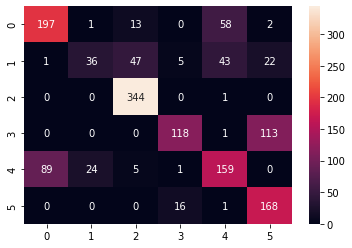

In [ ]:
# Fair baseline
import seaborn as sns
from sklearn.metrics import confusion_matrix

# d, g, k, s, t, z
# 0, 1, 2, 3, 4, 5

predictions = model_baseline.predict(test_us_data_baseline)

y_true = np.argmax(test_labels_us_baseline,axis=1)
y_pred = np.argmax(predictions,axis=1)

sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,fmt='d')

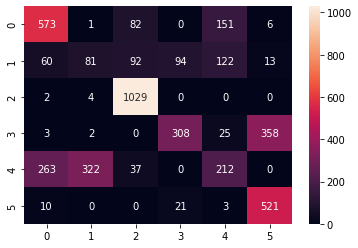

In [ ]:
# Here we use 3 frames for ResNet, this seems unfair
import seaborn as sns
from sklearn.metrics import confusion_matrix

# d, g, k, s, t, z
# 0, 1, 2, 3, 4, 5

predictions = model_baseline.predict(test_us_data_baseline)

y_true = np.argmax(test_labels_us_baseline,axis=1)
y_pred = np.argmax(predictions,axis=1)

sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,fmt='d')

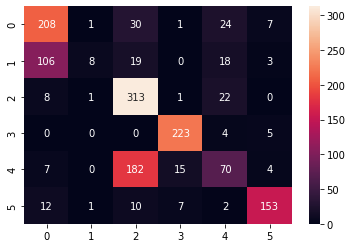

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# d, g, k, s, t, z
# 0, 1, 2, 3, 4, 5

predictions = model_s.predict(test_spec_data_reshape)

y_true = np.argmax(test_labels_us,axis=1)
y_pred = np.argmax(predictions,axis=1)

sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,fmt='d')

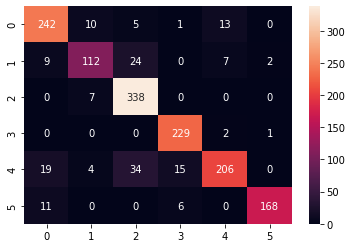

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# d, g, k, s, t, z
# 0, 1, 2, 3, 4, 5

predictions = model_t3.predict([test_us_data,test_spec_data])

y_true = np.argmax(test_labels_us,axis=1)
y_pred = np.argmax(predictions,axis=1)

sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,fmt='d')

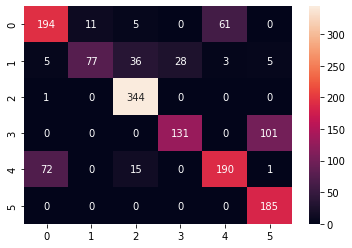

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# d, g, k, s, t, z
# 0, 1, 2, 3, 4, 5

predictions = model_f.predict(test_us_data)

y_true = np.argmax(test_labels_us,axis=1)
y_pred = np.argmax(predictions,axis=1)

sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,fmt='d')

In [ ]:
from tensorflow.keras.models import model_from_json

def get_loaded_model_by_name(filename):
  # load json and create model
  json_file = open(f'all_models/{filename}.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights(f'all_models/{filename}.h5')
  print("Loaded model from disk")
  print(loaded_model.summary())
  return loaded_model


In [ ]:
# for similarity
# 
# 
def get_similarity_results(out_arr, d_ind,t_ind, k_ind, g_ind, s_ind, z_ind):

  allArrays = np.array([])
  for d, t, k, g in zip(d_ind,t_ind, k_ind, g_ind):
    print(d,t,k,g)
    test_1 = out_arr[d]- out_arr[t] + out_arr[k]
    test_2 = out_arr[g]

    sim = get_similarty(test_1,test_2)

    print(sim)


def get_index_lists_phonemes_similarity(labels):
  dec_labels = decodedOneHot(labels)
  indexes_d = np.where(dec_labels == 0)
  indexes_t = np.where(dec_labels == 4)
  indexes_k = np.where(dec_labels == 2)
  indexes_g = np.where(dec_labels == 1)
  indexes_s = np.where(dec_labels == 3)
  indexes_z = np.where(dec_labels == 5)

  d_ind = indexes_d[0].tolist()
  t_ind = indexes_t[0].tolist()
  k_ind = indexes_k[0].tolist()
  g_ind = indexes_g[0].tolist()
  s_ind = indexes_s[0].tolist()
  z_ind = indexes_z[0].tolist()
  return d_ind,t_ind,k_ind,g_ind,s_ind,z_ind 


In [ ]:
from keras import backend as K
import numpy as np 
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px # for data visualization
 
def get_samples(data,label,size = 1000):
  n = size
  index = np.random.choice(data.shape[0], n, replace=False)
  data_random = data[index]
  label_random = label[index]
  return data_random,label_random

def get_samples_multi_input(data_us,label_us, data_spec, label_spec,size = 1000):
  n = size
  index = np.random.choice(data_us.shape[0], n, replace=False)
  data_random_us = data_us[index]
  label_random_us = label_us[index]
  data_random_spec = data_spec[index]
  label_random_spec = label_spec[index]
  return data_random_us,label_random_us, data_random_spec, label_random_spec

def frequencies_list(list_):
  (unique, counts) = np.unique(list_, return_counts=True)
  frequencies = np.asarray((unique, counts)).T
  return frequencies

def frequencies_list_with_max_cnt_index(list_):
  (unique, counts) = np.unique(list_, return_counts=True)
  frequencies = np.asarray((unique, counts)).T
  max_count_index = frequencies[np.where(counts == max(counts))]
  return frequencies, max_count_index


def frequencies(np_labels):
  np_inverted_labels = decodedOneHot(np_labels)
  (unique, counts) = np.unique(np_inverted_labels, return_counts=True)
  frequencies = np.asarray((unique, counts)).T
  return frequencies

def decodedOneHot(np_labels):
  inverted = np.argmax(np_labels,axis=1)
  return inverted

def get_layer_output_data_and_label(train_us_data, train_labels_us, loaded_model, train_spec_data = None, train_labels_spec = None,index_of_layer = -2, sample_size = 100, model_name="model_us_spec_all_phonemes"):
 
  is_multi_input = False
  if model_name == "model_us_spec_all_phonemes":
    is_multi_input = True
    tsne_data_us, tsne_label_us, tsne_data_spec, tsne_label_spec = get_samples_multi_input(train_us_data, train_labels_us, train_spec_data, train_labels_spec,sample_size)
  elif model_name == "model_us_all_phonemes":
    tsne_data_us, tsne_label_us = get_samples(train_us_data, train_labels_us, sample_size)
    print(tsne_data_us.shape)
  elif model_name == "model_spec_all_phonemes":
    tsne_data_spec, tsne_label_spec = get_samples(train_spec_data, train_labels_spec, sample_size)
    print(tsne_data_spec.shape)
  else:
    print("model not found")

  func = K.function([loaded_model.input], [loaded_model.layers[index_of_layer].output])

  print("IS MULTI INPUT: {}".format(is_multi_input))
  if is_multi_input:
    outputs = func([tsne_data_us, tsne_data_spec])
  else:
    if model_name == "model_us_all_phonemes":
      outputs = func([tsne_data_us])
    elif model_name == "model_spec_all_phonemes":
      print(tsne_data_spec.shape)
      tsne_data_spec = tsne_data_spec.reshape(100, 1, tsne_data_spec.shape[1], tsne_data_spec.shape[2], tsne_data_spec.shape[3])
      outputs = func([tsne_data_spec])

  out_arr = np.array(outputs,dtype=np.float64)
  out_arr = out_arr.reshape(out_arr.shape[1], out_arr.shape[2])
  print(out_arr.shape)
  if is_multi_input or model_name == "model_us_all_phonemes":
    return out_arr, tsne_label_us
  else:
    return out_arr, tf.keras.utils.to_categorical(tsne_label_spec)


def display_tsne(X_embedded, labels, is_analogy = False):

  if (is_analogy == False):
    color_labels = decodedOneHot(labels).astype(str)
  else: 
    color_labels = labels.astype(str)

  fig = px.scatter(None, x=X_embedded[:,0], y=X_embedded[:,1], 
                  labels={
                      "x": "Dimension 1",
                      "y": "Dimension 2",
                  },
                  opacity=1, color=color_labels)

  # Change chart background color
  fig.update_layout(dict(plot_bgcolor = 'white'))

  # Update axes lines
  fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                  zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                  showline=True, linewidth=1, linecolor='black')

  fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                  zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                  showline=True, linewidth=1, linecolor='black')

  # Set figure title
  fig.update_layout(title_text="t-SNE")

  # Update marker size
  fig.update_traces(marker=dict(size=3))

  fig.show()




In [ ]:
from numpy import dot
from numpy.linalg import norm
# print("for g: {0} for d: {1}, t: {2}, k:{3} Simlarity is:{4}".format(g,d,t,k,sim))

def analogy_switch(out_arr,d_ind,t_ind,k_ind,g_ind,s_ind,z_ind, case="d-t+k"):
  
  test_1_list = []

  if case == "d-t+k":
    print("Case works")
    print(case)
    for d in d_ind:
      for t in t_ind:
        for k in k_ind:
          test_1_list.append(out_arr[d] - out_arr[t] + out_arr[k])
  elif case == "t-d+k":
    print(case)
    for d in d_ind:
      for t in t_ind:
        for k in k_ind:
          test_1_list.append(out_arr[t] - out_arr[d] + out_arr[k])
  elif case == "z-s+t":
    print(case)
    for z in z_ind:
      for s in s_ind:
        for k in k_ind:
          test_1_list.append(out_arr[z] - out_arr[s] + out_arr[k])
  elif case =="s-z+t": 
    print(case)
    for s in s_ind:
      for z in z_ind:
        for t in t_ind:
          test_1_list.append(out_arr[s] - out_arr[z] + out_arr[t])
  elif case == "k-g+z":
    print(case)
    for k in k_ind:
      for g in g_ind:
        for z in z_ind:
          test_1_list.append(out_arr[k] - out_arr[g] + out_arr[z])
  elif case == "g-k+z":
    print(case)
    for g in g_ind:
      for k in k_ind:
        for z in z_ind:
          test_1_list.append(out_arr[g] - out_arr[k] + out_arr[z])
  elif case == "d-t+s":
    print(case)
    for d in d_ind:
      for t in t_ind:
        for s in s_ind:
          test_1_list.append(out_arr[d] - out_arr[t] + out_arr[s])
  elif case == "t-d+s":
    print(case)
    for d in d_ind:
      for t in t_ind:
        for s in s_ind:
          test_1_list.append(out_arr[t] - out_arr[d] + out_arr[s])


  else:
    print("case not found")
  
  return test_1_list


    

def get_test_1_list(out_arr,d_ind,t_ind,k_ind,g_ind,s_ind,z_ind, case="d-t+k"):
  return  analogy_switch(out_arr,d_ind,t_ind,k_ind,g_ind,s_ind,z_ind,case)


def all_sim(out_arr,d_ind,t_ind,k_ind,g_ind,s_ind,z_ind, case="d-t+k"):

  
  
  test_1_list = analogy_switch(out_arr,d_ind,t_ind,k_ind,g_ind,s_ind,z_ind,case)
  print(len(test_1_list))

  similarty_max_list = []
  similarty_second_max_list = []
  index_list = []
  index_second_list = []

  #  For each analogy
  for a in range(len(test_1_list)):
    highest = 0
    second_highest = 0
    test_1 = test_1_list[a]
    # print("came here")

    # Max and Second Max
    for i in range(len(out_arr)):
      test_2 = out_arr[i]
      similarity_result = get_similarty(test_1,test_2)
      # print("came here max")

      if similarity_result > highest:
        second_highest = highest
        highest = similarity_result
        index_i = i
      elif similarity_result > second_highest:
        second_highest = similarity_result
        index_j = i 

    similarty_max_list.append(highest)
    index_list.append(index_i)

    similarty_second_max_list.append(second_highest)
    index_second_list.append(index_j)


  return similarty_max_list, index_list, similarty_second_max_list, index_second_list


def get_similarty(a, b):
  cos_sim = dot(a, b)/(norm(a)*norm(b))
  return cos_sim

a = [1,0,0]
b = [1,0,0]
get_similarty(a,b)

1.0

In [ ]:

def get_medoids_of_clusters(out_arr,d_ind,t_ind,k_ind,g_ind,s_ind,z_ind):
  d_arr = np.zeros([out_arr.shape[1]])
  t_arr = np.zeros([out_arr.shape[1]])
  k_arr = np.zeros([out_arr.shape[1]])
  g_arr = np.zeros([out_arr.shape[1]])
  s_arr = np.zeros([out_arr.shape[1]])
  z_arr = np.zeros([out_arr.shape[1]])
  
  for d in d_ind:
      d_arr += out_arr[d]
  d_avg = d_arr / len(d_ind)
  
  for t in t_ind:
      t_arr += out_arr[t]
  t_avg = t_arr / len(t_ind)

  for g in g_ind:
      g_arr += out_arr[g]
  g_avg = g_arr / len(g_ind)

  for k in k_ind:
      k_arr += out_arr[k]
  k_avg = k_arr / len(k_ind)
  
  for s in s_ind:
      s_arr += out_arr[s]
  s_avg = s_arr / len(s_ind)

  for z in z_ind:
      z_arr += out_arr[z]
  z_avg = z_arr / len(z_ind)
  print(d_avg.shape)
  return d_avg, t_avg, k_avg, g_avg, s_avg, z_avg



In [ ]:
def main():
  
  # "model_spec_all_phonemes","model_us_all_phonemes",
  model_list = ["model_us_spec_all_phonemes","model_spec_all_phonemes","model_us_all_phonemes"]

  for model_name in model_list:

    # output layer display
    loaded_model = get_loaded_model_by_name(model_name)
    out_arr, labels = get_layer_output_data_and_label(train_us_data, train_labels_us, loaded_model,train_spec_data, train_labels_spec, sample_size = 100,model_name = model_name)
    # out_arr, labels = get_layer_output_data_and_label(train_us_data, train_labels_us, loaded_model, sample_size = 100)
    X_embedded = TSNE(n_components=2,init='random').fit_transform(out_arr)
    print("labelsshape: {}".format( labels.shape))
    if model_name == "model_spec_all_phonemes":
      display_tsne(X_embedded, labels)
      # similarity
      d_ind,t_ind,k_ind,g_ind,s_ind,z_ind  = get_index_lists_phonemes_similarity(labels)
    else:
      display_tsne(X_embedded, labels)
      # similarity
      d_ind,t_ind,k_ind,g_ind,s_ind,z_ind  = get_index_lists_phonemes_similarity(labels)

    case_list = ["d-t+k","s-z+t", "k-g+z", "d-t+s"]

    for case in case_list:

      abcdtest= get_test_1_list(out_arr,d_ind,t_ind,k_ind,g_ind,s_ind,z_ind, case=case)


      # get cluster medoids
      sim_list_d = []
      sim_list_t = []
      sim_list_k = []
      sim_list_g = []
      sim_list_s = []
      sim_list_z = []
      d_avg, t_avg, k_avg, g_avg, s_avg, z_avg = get_medoids_of_clusters(out_arr,d_ind,t_ind,k_ind,g_ind,s_ind,z_ind)
      for i in range(len(abcdtest)):
        sim_list_d.append(get_similarty(d_avg, abcdtest[i]))
        sim_list_t.append(get_similarty(t_avg, abcdtest[i]))
        sim_list_k.append(get_similarty(k_avg, abcdtest[i]))
        sim_list_g.append(get_similarty(g_avg, abcdtest[i]))
        sim_list_s.append(get_similarty(s_avg, abcdtest[i]))
        sim_list_z.append(get_similarty(z_avg, abcdtest[i]))

      all_tuple = zip(sim_list_d, sim_list_t, sim_list_k, sim_list_g, sim_list_s, sim_list_z)
      aList = list(all_tuple)

      class_list = []
      for i in range(len(aList)):
        temp = max(aList[i])
        class_list.append(aList[i].index(temp))

      print("frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): {}".format(frequencies_list_with_max_cnt_index(class_list)))


    # case_list = ["d-t+k","s-z+t", "k-g+z", "d-t+s"]
    # print("################ Model Name is:{} ######################".format(model_name))

    # for case in case_list:

    #   similarty_max_list, index_list, similarty_second_max_list, index_second_list = all_sim(out_arr, d_ind,t_ind,k_ind,g_ind,s_ind,z_ind,case)
    #   print("CASE " + case + " RESULTS for analogy")
    #   print("Result in similarity list:{}".format(similarty_max_list))
    #   print("Result in index_max_list list:{}".format(index_list))
    #   print(frequencies_list(index_list))
    #   print("Result in similarity second list:{}".format(similarty_second_max_list))
    #   print("Result in index_second_max_list list:{}".format(index_second_list))
    #   print(frequencies_list(index_second_list))
    


    # print("indexes of s vectors: {}".format(s_ind))
    # print("indexes of z vectors: {}".format(z_ind))
    # print("indexes of t vectors: {}".format(t_ind))
    # print("indexes of d vectors: {}".format(d_ind))
    # print("indexes of k vectors: {}".format(k_ind))
    # print("indexes of g vectors: {}".format(g_ind))


if __name__ == "__main__":
    main()


Loaded model from disk
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_18_input (InputLayer)   [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 96, 96, 128)  18944       ['conv2d_18_input[0][0]']        
                                                                                                  
 conv2d_19 (Conv2D)             (None, 96, 96, 128)  147584      ['conv2d_18[0][0]']              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 96, 96, 64)   73792       ['conv2d_19[0][0]']              
                                                                       

[1, 5, 14, 19, 26, 29, 35, 42, 45, 61, 66, 75, 82, 85, 88, 91, 94]
[2, 9, 10, 17, 20, 31, 32, 34, 46, 48, 50, 52, 64, 70, 81, 92]
Case works
(96,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[   2, 1341],
       [   3, 4910],
       [   4,    5]]), array([[   3, 4910]]))
case 2 executed
(96,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[   0,  113],
       [   1, 1501],
       [   4, 2194]]), array([[   4, 2194]]))
case 3 executed
(96,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[   0,   19],
       [   1,  145],
       [   2,  312],
       [   3,    1],
       [   4, 1105],
       [   5, 3501]]), array([[   5, 3501]]))
case 4 is executed
(96,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[   0, 1982],
       [   1,    8],
       [   4, 1803],
       [   5,   15]]), array([[   0, 1982]]))
Loaded model from disk
Model: "sequential_20"
______________

[2, 9, 16, 20, 24, 36, 57, 61, 68, 70, 72, 77, 83, 95]
[15, 25, 26, 31, 37, 43, 46, 48, 64, 65, 66, 69, 73, 75, 78, 84, 86, 89, 97]
Case works
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[   0, 2719],
       [   1,  154],
       [   2,  142],
       [   3, 2571]]), array([[   0, 2719]]))
case 2 executed
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[   1,  896],
       [   2,   22],
       [   4, 5219]]), array([[   4, 5219]]))
case 3 executed
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[   0,    4],
       [   1,   31],
       [   2,  551],
       [   4,  190],
       [   5, 2794]]), array([[   5, 2794]]))
case 4 is executed
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[   0,  291],
       [   3,   51],
       [   4, 4712]]), array([[   4, 4712]]))
Loaded model from disk
Model: "sequential_8"
__________________________________

[2, 4, 8, 13, 16, 25, 45, 47, 64, 75, 90, 94, 96, 97]
[17, 31, 41, 48, 57, 59, 65, 66, 82, 83, 85, 89]
Case works
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[   0,  158],
       [   2, 5050]]), array([[   2, 5050]]))
case 2 executed
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[   1, 2992],
       [   4,   32]]), array([[   1, 2992]]))
case 3 executed
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[   2,   26],
       [   5, 4748]]), array([[   5, 4748]]))
case 4 is executed
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[   4, 3024]]), array([[   4, 3024]]))


In [ ]:
def main():
  
  # "model_spec_all_phonemes","model_us_all_phonemes",
  model_list = ["model_us_spec_all_phonemes","model_spec_all_phonemes","model_us_all_phonemes"]

  for model_name in model_list:

    # output layer display
    loaded_model = get_loaded_model_by_name(model_name)

    out_arr_list = []
    labels_list = []


    epoch_size = 4
    for i in range(epoch_size):
      out_arr, labels = get_layer_output_data_and_label(train_us_data, train_labels_us, loaded_model,train_spec_data, train_labels_spec, sample_size = 100,model_name = model_name)
      out_arr_list.append(out_arr)
      labels_list.append(labels)
    
    out_arr_all = np.asarray(out_arr_list)
    labels_all = np.asarray(labels_list)


    out_arr_all = out_arr_all.reshape(out_arr_all.shape[0]*out_arr_all.shape[1],out_arr_all.shape[2])
    labels_all = labels_all.reshape(labels_all.shape[0]*labels_all.shape[1],labels_all.shape[2] )



    print("out_arr_all.shape:{} ".format(out_arr_all.shape))

    # out_arr, labels = get_layer_output_data_and_label(train_us_data, train_labels_us, loaded_model, sample_size = 100)
    X_embedded = TSNE(n_components=2,init='random').fit_transform(out_arr_all)
    print("labelsshape: {}".format( labels_all.shape))
    if model_name == "model_spec_all_phonemes":
      display_tsne(X_embedded, labels_all)
      # similarity
      d_ind,t_ind,k_ind,g_ind,s_ind,z_ind  = get_index_lists_phonemes_similarity(labels_all)
    else:
      display_tsne(X_embedded, labels_all)
      # similarity
      d_ind,t_ind,k_ind,g_ind,s_ind,z_ind  = get_index_lists_phonemes_similarity(labels_all)

    case_list = ["d-t+k","s-z+t", "k-g+z", "d-t+s"]

    for case in case_list:

      abcdtest= get_test_1_list(out_arr_all,d_ind,t_ind,k_ind,g_ind,s_ind,z_ind, case=case)


      # get cluster centroids
      sim_list_d = []
      sim_list_t = []
      sim_list_k = []
      sim_list_g = []
      sim_list_s = []
      sim_list_z = []
      d_avg, t_avg, k_avg, g_avg, s_avg, z_avg = get_medoids_of_clusters(out_arr_all,d_ind,t_ind,k_ind,g_ind,s_ind,z_ind)
      for i in range(len(abcdtest)):
        sim_list_d.append(get_similarty(d_avg, abcdtest[i]))
        sim_list_t.append(get_similarty(t_avg, abcdtest[i]))
        sim_list_k.append(get_similarty(k_avg, abcdtest[i]))
        sim_list_g.append(get_similarty(g_avg, abcdtest[i]))
        sim_list_s.append(get_similarty(s_avg, abcdtest[i]))
        sim_list_z.append(get_similarty(z_avg, abcdtest[i]))

      all_tuple = zip(sim_list_d, sim_list_t, sim_list_k, sim_list_g, sim_list_s, sim_list_z)
      aList = list(all_tuple)

      class_list = []
      for i in range(len(aList)):
        temp = max(aList[i])
        class_list.append(aList[i].index(temp))

      print("frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): {}".format(frequencies_list_with_max_cnt_index(class_list)))


    # case_list = ["d-t+k","s-z+t", "k-g+z", "d-t+s"]
    # print("################ Model Name is:{} ######################".format(model_name))

    # for case in case_list:

    #   similarty_max_list, index_list, similarty_second_max_list, index_second_list = all_sim(out_arr, d_ind,t_ind,k_ind,g_ind,s_ind,z_ind,case)
    #   print("CASE " + case + " RESULTS for analogy")
    #   print("Result in similarity list:{}".format(similarty_max_list))
    #   print("Result in index_max_list list:{}".format(index_list))
    #   print(frequencies_list(index_list))
    #   print("Result in similarity second list:{}".format(similarty_second_max_list))
    #   print("Result in index_second_max_list list:{}".format(index_second_list))
    #   print(frequencies_list(index_second_list))
    


    # print("indexes of s vectors: {}".format(s_ind))
    # print("indexes of z vectors: {}".format(z_ind))
    # print("indexes of t vectors: {}".format(t_ind))
    # print("indexes of d vectors: {}".format(d_ind))
    # print("indexes of k vectors: {}".format(k_ind))
    # print("indexes of g vectors: {}".format(g_ind))


if __name__ == "__main__":
    main()


Loaded model from disk
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_18_input (InputLayer)   [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 96, 96, 128)  18944       ['conv2d_18_input[0][0]']        
                                                                                                  
 conv2d_19 (Conv2D)             (None, 96, 96, 128)  147584      ['conv2d_18[0][0]']              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 96, 96, 64)   73792       ['conv2d_19[0][0]']              
                                                                       

Case works
d-t+k
(96,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0,   5868],
       [     1,     96],
       [     2, 145626],
       [     3, 359534],
       [     4,    748]]), array([[     3, 359534]]))
case 2 executed
s-z+t
(96,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0,   3367],
       [     1,  58657],
       [     4, 252736]]), array([[     4, 252736]]))
case 3 executed
k-g+z
(96,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[    0,   959],
       [    1, 14178],
       [    2, 31289],
       [    3,     9],
       [    4, 60568],
       [    5, 93877]]), array([[    5, 93877]]))
case 4 is executed
d-t+s
(96,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0, 141661],
       [     1,   8511],
       [     4, 158667],
       [     5,  26905]]), array([[     4, 158667]]))
Loaded model from disk
Model: "sequential_20"
____

Case works
d-t+k
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0, 269079],
       [     1,  62623],
       [     2,  65931],
       [     3, 152394],
       [     4,    577],
       [     5,   6109]]), array([[     0, 269079]]))
case 2 executed
s-z+t
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0,    100],
       [     1,  26593],
       [     2,   3160],
       [     3,    565],
       [     4, 251421],
       [     5,     41]]), array([[     4, 251421]]))
case 3 executed
k-g+z
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0,    424],
       [     1,   1701],
       [     2,  50442],
       [     3,    145],
       [     4,   5183],
       [     5, 108479]]), array([[     5, 108479]]))
case 4 is executed
d-t+s
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0,  16588],
       [     1,    238],
       [     2,

Case works
d-t+k
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0,  50297],
       [     2, 526423]]), array([[     2, 526423]]))
case 2 executed
s-z+t
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     1, 260410],
       [     4,  18605]]), array([[     1, 260410]]))
case 3 executed
k-g+z
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     2,     54],
       [     5, 183096]]), array([[     5, 183096]]))
case 4 is executed
d-t+s
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0,   4003],
       [     4, 361253]]), array([[     4, 361253]]))


In [ ]:
def main():
  
  # "model_spec_all_phonemes","model_us_all_phonemes",
  model_list = ["model_us_spec_all_phonemes","model_spec_all_phonemes","model_us_all_phonemes"]

  for model_name in model_list:

    # output layer display
    loaded_model = get_loaded_model_by_name(model_name)

    out_arr_list = []
    labels_list = []


    epoch_size = 4
    for i in range(epoch_size):
      out_arr, labels = get_layer_output_data_and_label(train_us_data, train_labels_us, loaded_model,train_spec_data, train_labels_spec, sample_size = 100,model_name = model_name)
      out_arr_list.append(out_arr)
      labels_list.append(labels)
    
    out_arr_all = np.asarray(out_arr_list)
    labels_all = np.asarray(labels_list)


    out_arr_all = out_arr_all.reshape(out_arr_all.shape[0]*out_arr_all.shape[1],out_arr_all.shape[2])
    labels_all = labels_all.reshape(labels_all.shape[0]*labels_all.shape[1],labels_all.shape[2] )



    print("out_arr_all.shape:{} ".format(out_arr_all.shape))

    # out_arr, labels = get_layer_output_data_and_label(train_us_data, train_labels_us, loaded_model, sample_size = 100)
    X_embedded = TSNE(n_components=2,init='random').fit_transform(out_arr_all)
    print("labelsshape: {}".format( labels_all.shape))
    if model_name == "model_spec_all_phonemes":
      display_tsne(X_embedded, labels_all)
      # similarity
      d_ind,t_ind,k_ind,g_ind,s_ind,z_ind  = get_index_lists_phonemes_similarity(labels_all)
    else:
      display_tsne(X_embedded, labels_all)
      # similarity
      d_ind,t_ind,k_ind,g_ind,s_ind,z_ind  = get_index_lists_phonemes_similarity(labels_all)

    case_list = ["d-t+k","t-d+k","z-s+t","s-z+t", "k-g+z", "g-k+z","d-t+s","t-d+s"]

    for case in case_list:

      abcdtest= get_test_1_list(out_arr_all,d_ind,t_ind,k_ind,g_ind,s_ind,z_ind, case=case)


      # get cluster centroids
      sim_list_d = []
      sim_list_t = []
      sim_list_k = []
      sim_list_g = []
      sim_list_s = []
      sim_list_z = []
      d_avg, t_avg, k_avg, g_avg, s_avg, z_avg = get_medoids_of_clusters(out_arr_all,d_ind,t_ind,k_ind,g_ind,s_ind,z_ind)
      for i in range(len(abcdtest)):
        sim_list_d.append(get_similarty(d_avg, abcdtest[i]))
        sim_list_t.append(get_similarty(t_avg, abcdtest[i]))
        sim_list_k.append(get_similarty(k_avg, abcdtest[i]))
        sim_list_g.append(get_similarty(g_avg, abcdtest[i]))
        sim_list_s.append(get_similarty(s_avg, abcdtest[i]))
        sim_list_z.append(get_similarty(z_avg, abcdtest[i]))

      all_tuple = zip(sim_list_d, sim_list_t, sim_list_k, sim_list_g, sim_list_s, sim_list_z)
      aList = list(all_tuple)

      class_list = []
      for i in range(len(aList)):
        temp = max(aList[i])
        class_list.append(aList[i].index(temp))

      print("frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): {}".format(frequencies_list_with_max_cnt_index(class_list)))


    # case_list = ["d-t+k","s-z+t", "k-g+z", "d-t+s"]
    # print("################ Model Name is:{} ######################".format(model_name))

    # for case in case_list:

    #   similarty_max_list, index_list, similarty_second_max_list, index_second_list = all_sim(out_arr, d_ind,t_ind,k_ind,g_ind,s_ind,z_ind,case)
    #   print("CASE " + case + " RESULTS for analogy")
    #   print("Result in similarity list:{}".format(similarty_max_list))
    #   print("Result in index_max_list list:{}".format(index_list))
    #   print(frequencies_list(index_list))
    #   print("Result in similarity second list:{}".format(similarty_second_max_list))
    #   print("Result in index_second_max_list list:{}".format(index_second_list))
    #   print(frequencies_list(index_second_list))
    


    # print("indexes of s vectors: {}".format(s_ind))
    # print("indexes of z vectors: {}".format(z_ind))
    # print("indexes of t vectors: {}".format(t_ind))
    # print("indexes of d vectors: {}".format(d_ind))
    # print("indexes of k vectors: {}".format(k_ind))
    # print("indexes of g vectors: {}".format(g_ind))


if __name__ == "__main__":
    main()


Loaded model from disk
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_18_input (InputLayer)   [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 96, 96, 128)  18944       ['conv2d_18_input[0][0]']        
                                                                                                  
 conv2d_19 (Conv2D)             (None, 96, 96, 128)  147584      ['conv2d_18[0][0]']              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 96, 96, 64)   73792       ['conv2d_19[0][0]']              
                                                                       

Case works
d-t+k
(96,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0,   2060],
       [     1,    321],
       [     2,  73679],
       [     3, 314675],
       [     4,    873]]), array([[     3, 314675]]))
t-d+k
(96,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     1,    333],
       [     2, 357776],
       [     3,   2251],
       [     4,  31248]]), array([[     2, 357776]]))
z-s+t
(96,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     1,      3],
       [     2,  80518],
       [     3, 253000],
       [     4,     12],
       [     5,  48163]]), array([[     3, 253000]]))
s-z+t
(96,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0,   2626],
       [     1,  52038],
       [     2,     49],
       [     3,     10],
       [     4, 231549]]), array([[     4, 231549]]))
k-g+z
(96,)
frequency list as index (d,0) - (t,1) - (k,2) - (g

Case works
d-t+k
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0, 286905],
       [     1,  33711],
       [     2,  58056],
       [     3, 127054],
       [     4,    628],
       [     5,   5006]]), array([[     0, 286905]]))
t-d+k
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0,   2023],
       [     1,  53390],
       [     2, 446601],
       [     3,   4126],
       [     4,   3951],
       [     5,   1269]]), array([[     2, 446601]]))
z-s+t
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0,  18413],
       [     1,     98],
       [     2, 162105],
       [     3,  10842],
       [     5, 113854]]), array([[     2, 162105]]))
s-z+t
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0,     22],
       [     1,  32656],
       [     2,    241],
       [     3,     98],
       [     4, 226819],
       [     5, 

Case works
d-t+k
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     0,  43603],
       [     2, 412372],
       [     4,     25]]), array([[     2, 412372]]))
t-d+k
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     1, 131822],
       [     2, 324178]]), array([[     2, 324178]]))
z-s+t
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     2, 297977],
       [     5,  70243]]), array([[     2, 297977]]))
s-z+t
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     1, 238162],
       [     4,   9902]]), array([[     1, 238162]]))
k-g+z
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     2,    752],
       [     5, 221263]]), array([[     5, 221263]]))
g-k+z
(64,)
frequency list as index (d,0) - (t,1) - (k,2) - (g,3) - (s,4) - (z,5): (array([[     3,  39571],
       [     5, 182444]]), array([[     